In [6]:
# Download new aggregator dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2025-03-10 21:40:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [         <=>        ]  27.87M   707KB/s    in 22s     

2025-03-10 21:40:51 (1.29 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]



# 0.0 Import Dataset


In [1]:
import os
from zipfile import ZipFile

# from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkConf
from pyspark.sql import SparkSession, DataFrame, Row
from pyspark.sql.types import  ArrayType, StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import col, countDistinct, create_map, regexp_replace, split, lower, udf
from pyspark.ml import Pipeline, PipelineModel, Transformer
from pyspark.ml.feature import (
    Tokenizer, RegexTokenizer, StopWordsRemover, CountVectorizer, IDF,
    HashingTF, StringIndexer
)
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark import keyword_only
from nltk.stem import PorterStemmer


In [ ]:
#Not applicable if not run on google colab
# mount google drive disk:
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# path to the zip with data
src_zip_file='NewsAggregatorDataset.zip'

#destination path for extracted data
dst_path='./data/'
if not os.path.exists(dst_path):
    os.makedirs('./data/')

data_src='data/newsCorpora.csv'

In [3]:
def extract_zip(src_zip_file, dst_path):
    """
    Extracts all files from a ZIP archive to a specified destination directory.

    Args:
        src_zip_file (str): The path to the ZIP file to be extracted.
        dst_path (str): The destination directory where the files should be extracted.

    Returns:
        None

    Example:
        extract_zip("data.zip", "output_folder")

    This function:
    - Opens the given ZIP file.
    - Prints the list of files inside the ZIP archive.
    - Extracts all the files to the specified directory.
    - Prints a confirmation message upon successful extraction.
    """
    with ZipFile(src_zip_file, 'r') as zip:
        zip.printdir()  # Display the contents of the ZIP file
        zip.extractall(dst_path)  # Extract all files
        print(f"Files extracted to {dst_path}")


In [4]:
extract_zip(src_zip_file, dst_path)

File Name                                             Modified             Size
2pageSessions.csv                              2016-02-27 13:54:36      3049986
__MACOSX/                                      2016-02-28 22:41:32            0
__MACOSX/._2pageSessions.csv                   2016-02-27 13:54:36          239
newsCorpora.csv                                2016-02-27 13:54:36    102297000
__MACOSX/._newsCorpora.csv                     2016-02-27 13:54:36          239
readme.txt                                     2016-02-28 22:41:08         2593
__MACOSX/._readme.txt                          2016-02-28 22:41:08          510
Files extracted to ./data/


In [5]:
# Code below nitialize spark session for distributed data processing with configurations:
# allocate spark driver memory - 8gb
# run spark in local mode using 8 CPU cores
# "News Header Text Classification" spark application name, making it easier to identify when monitoring Spark Jobs
conf = SparkConf().set("spark.driver.memory", "8g")

spark = SparkSession.builder.master("local[8]")\
                                    .config(conf=conf)\
                                    .appName("News Header Text Classification").getOrCreate()



25/03/11 08:50:39 WARN Utils: Your hostname, AMDC4393 resolves to a loopback address: 127.0.1.1; using 106.120.87.145 instead (on interface eno1)
25/03/11 08:50:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/03/11 08:50:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
# Get the number of cores Spark is using
num_cores = spark.sparkContext.defaultParallelism
print(f"Spark is using {num_cores} cores.")

Spark is using 8 cores.


In [7]:
# Define the schema of the imported dataset. Since we do not yet know the nature of the data,
# all columns are set to nullable (True), except for the ID column, which serves as the key
# of the dataset and should not contain any null values.
schema = StructType([
    StructField('ID', IntegerType(), nullable=False),
    StructField('TITLE', StringType(), nullable=True),
    StructField('URL', StringType(), nullable=True),
    StructField('PUBLISHER', StringType(), nullable=True),
    StructField('CATEGORY', StringType(), nullable=True),
    StructField('STORY', StringType(), nullable=True),
    StructField('HOSTNAME', StringType(), nullable=True),
    StructField('TIMESTAMP', FloatType(), nullable=True),
])

df = spark.read.option("delimiter", "\t").csv(data_src, header=None, schema=schema)

# 1.0 Data Exploration

In [8]:
# forces the dataset to be split into 8 partitions
df = df.repartition(8)

## 1.1 Basic Statistics


In [9]:
df.printSchema()
print(f'The dataset contain such an number of columns: {len(df.columns)}')
df.show(truncate=False)

root
 |-- ID: integer (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- PUBLISHER: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- STORY: string (nullable = true)
 |-- HOSTNAME: string (nullable = true)
 |-- TIMESTAMP: float (nullable = true)

The dataset contain such an number of columns: 8


+-----+-----------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+--------+-----------------------------+--------------------------+-------------+
|ID   |TITLE                                                                              |URL                                                                                                                                                                                                                                                   |PUBLISHER                   |CATEGORY|STORY                        |HOSTNAME                  |TIMESTAMP    |
+-----+-----------------------------------------------------------------------------------+-------------

In [10]:
df.show(1, truncate=False)

+-----+------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+----------------------------+--------+-----------------------------+---------------+------------+
|ID   |TITLE                                                                   |URL                                                                                                                     |PUBLISHER                   |CATEGORY|STORY                        |HOSTNAME       |TIMESTAMP   |
+-----+------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+----------------------------+--------+-----------------------------+---------------+------------+
|20672|Possible Oldest Cancer Found In 3000-Year-Old Skeleton Could Reveal  ...|http://www.ibtimes.com/

Interpretation of processed dataset:
* Dataset contains 8 columns, which include:ID, TITLE, URL, PUBLISHER, CATEGORY, STORY, HOSTNAME, and TIMESTAMP.
* Almost all columns are nullable, which mean that the can contain missing or null values, except for ID and TITLE.
* Data types are varied, but mostly occurs stringtype columns, one column with integer - ID, and one with floating-point number - TIMESTAMP, which suggests that the timestamp might represent time in a numeric form

In [26]:
category_count = df.groupBy('TITLE').agg(countDistinct('CATEGORY').alias('distinct_category_count'))
# Filter to find titles with more than one distinct category
titles_with_multiple_categories = category_count.filter(col('distinct_category_count') > 1)

# Show the results
titles_with_multiple_categories.count()

788

In [ ]:
titles_with_multiple_categories.show(truncate=False)

In [ ]:
df.filter(col('TITLE')=='Turmoil in Iraq is pushing up US gasoline prices').show(truncate=False)

In [40]:
print(f'Only around {round(titles_with_multiple_categories.count()/ df.select("TITLE").distinct().count()  * 100, 2)} % of whole unique titles has two categories ')

Only around 0.19 % of whole unique titles has two categories 


In [15]:
df.dtypes

[('ID', 'int'),
 ('TITLE', 'string'),
 ('URL', 'string'),
 ('PUBLISHER', 'string'),
 ('CATEGORY', 'string'),
 ('STORY', 'string'),
 ('HOSTNAME', 'string'),
 ('TIMESTAMP', 'float')]

In [16]:
print(f'Total number of rows in a dataset: {df.count()}')

Total number of rows in a dataset: 422937


In order to interprate the number of rows, we have to consider in which framework we the processing will be performed.

* 422937 is small number of rows for Spark, but quite big for Pandas.
* in this enviroment we are using 1 worker node and 4 cores, which is not ideal solution for spark, nevertheless, the computation are feasibile with the adequate memory management like adjusting partitions.

In [41]:
# collect basic statistics to a list
def prepare_basic_statistics(dataframe):

    """
    Function computes basic statistics for each column in the given PySpark DataFrame.

    The function returns a list of tuples, where each tuple contains:
    - Column name
    - Column data type
    - Number of distinct values in the column
    - Number of null (missing) values in the column

    Args:
        df (DataFrame): A PySpark DataFrame to analyze.

    Returns:
        list of tuples: A list where each tuple represents:
            (column_name, column_type, distinct_value_count, null_value_count)
    """
    statistics_list=[]

    for k in dataframe.columns:
      distinct_values = df.select(k).distinct().count()
      nullRows = df.where(col(k).isNull()).count()
      column_type = df.select(k).dtypes[0][1]
      temp=k, column_type, distinct_values, nullRows
      statistics_list.append(temp)

    return statistics_list

# print(statistics_list)
cnt_statistics = prepare_basic_statistics(df)

In [42]:
# define schema for basic statistics
schema = StructType([
    StructField("Column Name", StringType()),
    StructField("Columns type", StringType()),
    StructField("Cnt Distinct", IntegerType()),
    StructField("CNT NULL", IntegerType()),
])

# Create DataFrame with basic statistics
basic_statistics = spark.createDataFrame(cnt_statistics, schema)
basic_statistics.show()

+-----------+------------+------------+--------+
|Column Name|Columns type|Cnt Distinct|CNT NULL|
+-----------+------------+------------+--------+
|         ID|         int|      422937|       0|
|      TITLE|      string|      406940|       0|
|        URL|      string|      422733|       9|
|  PUBLISHER|      string|       10993|      11|
|   CATEGORY|      string|           5|       9|
|      STORY|      string|        7232|       9|
|   HOSTNAME|      string|       11243|       9|
|  TIMESTAMP|       float|        7668|       9|
+-----------+------------+------------+--------+



## 1.2 Handle Missing Values

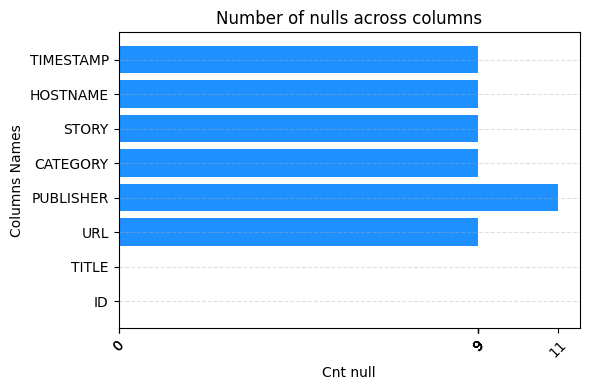

In [16]:
# prepare data for visualization
columns_names = [row['Column Name'] for row in basic_statistics.collect()]
cnt_nulls = [row['CNT NULL'] for row in basic_statistics.collect()]

# creating the bar plot
plt.figure(figsize=(6,4))
plt.barh(columns_names, cnt_nulls , color ='dodgerblue')

plt.title("Number of nulls across columns")  # Add title
plt.xlabel("Cnt null")  # Add x-axis label
plt.ylabel("Columns Names")

# Rotate the x-axis labels
plt.xticks(cnt_nulls, rotation=45)

#Adjust layout to make sure everything fits
plt.tight_layout()

# Add grid lines for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

Only **TITLE** and **CATEGORY** columns will be used for Futher exploration.
The main task is to perform news aggregator classification task, whereas, CATEGORY is the variable with predicted labels (Y), and TITLE is variable used to prepare prediction (X).

Explanation, why **TITLE** is only one variable to perform prediction:
* ***concise information***: TITLE, which can be interpret as headlines are designed to capture the essence of the news article in a short and concise format. They usually summarize the most important aspects of the news, including the main topic, event, and key details.
By focusing on the headline, the model doesn't have to process a large volume of text. It can focus on a small, but highly informative part of the content, which is enough for classification tasks.
* ***Headline often reflects category***: In many cases, the category or label of the news (e.g., politics, sports, technology) is clear from the words used in the headline. So for multi-class classification tasks provide it enough information to accurately predict the class.


In [43]:
df_categories = df.select('TITLE', 'CATEGORY')

In [44]:
category_null_percentage = round(df_categories.where(col("CATEGORY").isNull()).count() / df_categories.count() * 100, 4)

In [45]:
# As, TITLE does not have null, but CATEGORY has, but only around 9 rows
# The percentage of null for CATEGORY is:
print(f"The percentage of null for variable CATEGORY is insignificant: {category_null_percentage }%")
# So, the missing values could be deleted as, it does not have impact on the overall dataset
df_categories = df_categories.dropna(how='any')

The percentage of null for variable CATEGORY is insignificant: 0.0021%


In [46]:
df_categories.where(col("CATEGORY").isNull()).count()

0

In [47]:
value_counts_categories = df_categories.groupBy("category").count()
value_counts_categories.show()

+--------+------+
|category| count|
+--------+------+
|       m| 45639|
|       e|152821|
|       b|115967|
|       t|108501|
+--------+------+



In [48]:
categories = ['health','entertainment','business','science']
cnt_categories = [row['count'] for row in value_counts_categories.collect()]

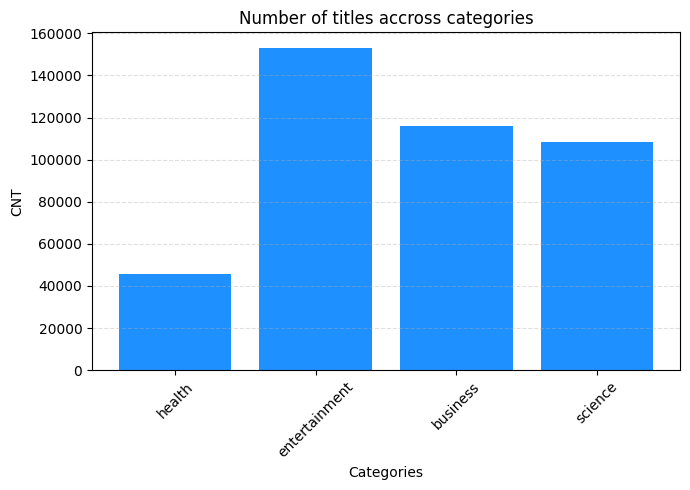

In [49]:
# creating the bar plot
plt.figure(figsize=(7,5))
plt.bar(categories, cnt_categories, color ='dodgerblue')

plt.title("Number of titles accross categories")  # Add title
plt.xlabel("Categories")  # Add x-axis label
plt.ylabel("CNT")

# Rotate the x-axis labels
plt.xticks(categories , rotation=45)

#Adjust layout to make sure everything fits
plt.tight_layout()

# Add grid lines for the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

The most important conclusion from this brief analysis is that, we have **Imbalanced Class**, model can have biased towrd the larger class, and have poor performance on the smaller class.

Approaches to handle with such an imbalanced classes, which will be applied in this analysis:
1. Choosing **evaluation metrics**, suitable for an imbalanced class: Precision, Recall, F1-Score, especially macro-average F1
2. Applying **ensemble methods** like Random Forest or Gradient Boosting, which can help improve performance on imbalanced datasets because they are more robust and can handle variance in data better.
XGBoost / LightGBM: Implement advanced techniques for dealing with imbalanced data, including the ability to assign class weights directly during training.


# 2.0 Data Preprocessing

In [24]:
df_categories.show(truncate=False)


+---------------------------------------------------------------------------+--------+
|TITLE                                                                      |CATEGORY|
+---------------------------------------------------------------------------+--------+
|Fed official says weak data caused by weather, should not slow taper       |b       |
|Fed's Charles Plosser sees high bar for change in pace of tapering         |b       |
|US open: Stocks fall after Fed official hints at accelerated tapering      |b       |
|Fed risks falling 'behind the curve', Charles Plosser says                 |b       |
|Fed's Plosser: Nasty Weather Has Curbed Job Growth                         |b       |
|Plosser: Fed May Have to Accelerate Tapering Pace                          |b       |
|Fed's Plosser: Taper pace may be too slow                                  |b       |
|Fed's Plosser expects US unemployment to fall to 6.2% by the end of 2014   |b       |
|US jobs growth last month hit by weather:F

## 2.1 Create pipeline for Data transformation

### 2.1.1 Prepare customize transformers

In [ ]:
# Preparation of stemming transformer
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem words in an ArrayType column
def stem_words(list_words):
    return [stemmer.stem(word) for word in list_words]

# UDF for stemming
stem_udf = udf(stem_words, ArrayType(StringType()))


class StemmingTransformer(Transformer):
    """
    A custom PySpark Transformer that applies stemming to a specified column of tokenized words.

    Attributes:
        input_col (str): The name of the input column to apply the stemming to.
        output_col (str): The name of the output column where the stemmed data will be stored.

    Methods:
        _transform(df): Applies stemming to the input column and creates a new output column
                         with the stemmed words.
    """

    def __init__(self, input_col, output_col):
        super(StemmingTransformer, self).__init__()
        self.input_col = input_col
        self.output_col = output_col

    def _transform(self, df):
        """
        Apply stemming using a UDF to transform the input column into the output column with stemmed words.
        """
        df_stemmed = df.withColumn(self.output_col, stem_udf(col(self.input_col)))
        return df_stemmed


### 2.1.2 Prepare the processing pipeline for TITLE variable

In [41]:

def preprocess_title_column(df, input_col="TITLE", output_col="title_only_str"):
    """
    Cleans the specified text column by:
    - Converting text to lowercase
    - Removing non-alphanumeric characters (excluding spaces)
    - Removing digits

    Args:
        df (DataFrame): The input Spark DataFrame.
        input_col (str): The name of the column to be cleaned (default: "TITLE").
        output_col (str): The name of the new column storing the cleaned text (default: "title_only_str").

    Returns:
        DataFrame: A new DataFrame with the additional cleaned column.
    """
    return df.withColumn(output_col, lower(regexp_replace(col(input_col), r'[^\w\s]|[0-9]+', '')))



In [ ]:
# 1. Clean the Title text from any character that is not a word character, space and lower case all the letter
df_categories = df_categories.withColumn(
    'title_only_str', lower(regexp_replace(col('TITLE'), r'[^\w\s]|[0-9]+', ''))  # Replace non-alphanumeric characters and digits
)
# run function preprocess_title_column
df_categories = preprocess_title_column(df_categories)

# 2. Tokenie the sentences
# In tasks like text classification, focusing on longer, more significant tokens
# can improve model accuracy by removing unnecessary noise because of that minTokenLength has been set
tokenizer = RegexTokenizer(minTokenLength=2, inputCol='title_only_str', outputCol='title_words', pattern="\\W")

# 3.  remove stop words
stop_words_remover = StopWordsRemover(inputCol='title_words', outputCol='title_clean_words')

# 4. Apply stemming Transformer - customized one - stemming cannot be applied - explanation in presentation:
# stemming_transformer = StemmingTransformer(input_col='title_clean_words', output_col='stemmed_words')
# cleaned_df = df_transformed2.withColumn("stemmed_words", stem_udf(col('title_clean_words')))


# 5. Initialize CountVectorizer
count_vec = CountVectorizer(inputCol='title_clean_words' ,
                            outputCol='words_vectorized',
                            maxDF=0.9,
                            minDF=2,
                            minTF=1
                            )

# 6. Initilaize Inverse Document Frequency
idf = IDF(inputCol='words_vectorized', outputCol = 'words_tfidf')


# Create a reusabble pipeline with all above defined transformation
pipeline = Pipeline(stages=[tokenizer, stop_words_remover, count_vec, idf])
pipeline_model = pipeline.fit(df_categories)

ddf_categories = pipeline_model.transform(df_categories)


In [ ]:
ddf_categories.show(truncate=False)

+--------------------------------------------------------------------------------------+--------+-------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TITLE                                                                                 |CATEGORY|title_only_str                                                                 |title_words                                                                                   |title_clean_words                           

In [33]:
# Save the model to a specified path
model_save_path_pipeline = "/content/drive/MyDrive/Colab Notebooks/pipeline_model2"
pipeline_model.write().overwrite().save(model_save_path_pipeline)

#### 2.1.2.1 Test Loaded model

In [43]:

model_save_path_pipeline = "/content/drive/MyDrive/Colab Notebooks/pipeline_model2"
# Load the pipeline model back
loaded_pipeline_model = PipelineModel.load(model_save_path_pipeline)

# perform initial preprocessing: select columns, and replace unnecessary chars and digits
test_dataset = df.select('TITLE', 'CATEGORY')
test_dataset= preprocess_title_column(test_dataset)
# Apply the loaded model to new data
loaded_transformed_df = loaded_pipeline_model.transform(test_dataset)
loaded_transformed_df.show(truncate=False)

+---------------------------------------------------------------------------+--------+----------------------------------------------------------------------+---------------------------------------------------------------------------------+-----------------------------------------------------------------------------+--------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TITLE                                                                      |CATEGORY|title_only_str                                                        |title_words                                                                      |title_clean_words                                                            |words_vectorized                                   

## 2.2 Prepare explanatory variable - Category

Process categorical values to numerical

In [86]:
# Convert labels into numeric values using StringIndexer
indexer = StringIndexer(inputCol="CATEGORY", outputCol="indexed_label2")
indexed_model = indexer.fit(ddf_categories)
ddf_categories = indexed_model.transform(ddf_categories)

In [50]:
ddf_categories.show(2, truncate=False)

+--------------------------------------------------------------------+--------+-------------------------------------------------------------------+--------------------------------------------------------------------------------+---------------------------------------------------------------+-----------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
|TITLE                                                               |CATEGORY|title_only_str                                                     |title_words                                                                     |title_clean_words                                              |words_vectorized                                                                   |words_tfidf            

Prepare mapping dictionary from numbers into categories

In [ ]:
lista = indexed_model.labels

In [108]:
print("Label to index mapping:")
for idx, label in enumerate(lista):
    print(f"{idx} -> {label}")

Label to index mapping:
0 -> e
1 -> b
2 -> t
3 -> m


Save Indexer Model

In [91]:
indexed_model.save("/content/drive/MyDrive/Colab Notebooks/string_indexer_model_final")

# 3.0 Model Training & Selection

In [55]:
selected_features = ddf_categories.select('words_tfidf', 'indexed_label')

In [142]:
#Create our Training & Test datasets
(trainingData, testData) = selected_features.randomSplit([0.8, 0.2],seed = 11)

## 3.1 Naive Bayes

In [63]:
# define naive bayes model
nb = NaiveBayes(modelType="multinomial", featuresCol='words_tfidf', labelCol='indexed_label')

# define Hyperparameter Grid
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.1, 1.0, 2.0]).build() # Try different smoothing values

# Define Evaluator (F1-Score)
evaluator = MulticlassClassificationEvaluator(labelCol="indexed_label", predictionCol="prediction" )
                                              # metricName="f1")

# Cross Validation Setup
cv = CrossValidator(
    estimator=nb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5  # 5-Fold Cross Validation
)

cv_model = cv.fit(trainingData)

# Get Best Model from Cross-Validation
best_model = cv_model.bestModel

# Make Predictions on Test Data
test_predictions = best_model.transform(testData)

# Evaluate the Best Model on Test Data using Multiple Metrics
# Precision
precision = evaluator.setMetricName("weightedPrecision").evaluate(test_predictions)
print(f"Precision: {precision}")

# Recall
recall = evaluator.setMetricName("weightedRecall").evaluate(test_predictions)
print(f"Recall: {recall}")

# F1-Score
f1_score = evaluator.setMetricName("f1").evaluate(test_predictions)
print(f"F1-Score: {f1_score}")

Precision: 0.9292756781429855
Recall: 0.9287983841438205
F1-Score: 0.9289019603652084


In [184]:
evaluation_metrics = []
evaluation_metrics.append(["Naive Bayes", round(precision, 4), round(recall, 4), round(f1_score, 4)] )


In [185]:
# define schema for basic metrics
schema = StructType([
    StructField("Machine_Learning_Model", StringType(), nullable=False),
    StructField("Precision",  FloatType(), nullable=True),
    StructField("Recall", FloatType(), nullable=True),
    StructField("F1_Score", FloatType(), nullable=True),
])


# Create DataFrame with basic statistics
evaluation_metrics_df = spark.createDataFrame(evaluation_metrics, schema)
evaluation_metrics_df.show()

+----------------------+---------+------+--------+
|Machine_Learning_Model|Precision|Recall|F1_Score|
+----------------------+---------+------+--------+
|           Naive Bayes|   0.9293|0.9288|  0.3959|
+----------------------+---------+------+--------+



In [65]:
print(best_model)

NaiveBayesModel: uid=NaiveBayes_544a69f734a3, modelType=multinomial, numClasses=4, numFeatures=38174


Save model to disk

In [ ]:
import shutil
import os
# Check if the directory exists, and remove it if needed
if os.path.exists("/content/drive/MyDrive/Colab Notebooks/naive_bayesian_final"):
    shutil.rmtree("/content/drive/MyDrive/Colab Notebooks/naive_bayesian_final")

In [67]:
# Save the trained Naive Bayes model
model_save_path_nb = "/content/drive/MyDrive/Colab Notebooks/naive_bayesian_final"
best_model.write().overwrite().save(model_save_path_nb)

## 3.2 Random Forest

In [146]:
# Data are already splitted for the previous moodel: (trainingData, testData)

(DataFrame[words_tfidf: vector, indexed_label: double],
 DataFrame[words_tfidf: vector, indexed_label: double])

In [ ]:
# Define Model
rf = RandomForestClassifier(featuresCol='words_tfidf', labelCol="indexed_label")

# Hyperparameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Define Evaluator (F1-Score)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexed_label", metricName="f1")


#  Seting Up Cross-Validation
cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_f1,
    numFolds=3  # 3-Fold Cross Validation, for more optimized calculations
)

# Train with Cross-Validation
cv_model_rf = cv.fit(trainingData)

# Generate predictions
test_predictions = cv_model_rf.transform(testData)


In [203]:
# Evaluate with F1 scores
f1_score = evaluator_f1.evaluate(test_predictions)
print(f"Final Test F1-Score: {f1_score:.4f}")

Final Test F1-Score: 0.3959


In [204]:
#  Best Model Parameters
best_model = cv_model_rf.bestModel
print("Best Parameters:")
print(f" - Num Trees: {best_model.getNumTrees}")
print(f" - Max Depth: {best_model.getMaxDepth}")


Best Parameters:
 - Num Trees: 10
 - Max Depth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_079e66637fed, numTrees=10, numClasses=4, numFeatures=38174>


Save Model to disk

In [151]:
import shutil
import os
# Check if the directory exists, and remove it if needed
if os.path.exists("/content/drive/MyDrive/Colab Notebooks/model_randomForest_1"):
    shutil.rmtree("/content/drive/MyDrive/Colab Notebooks/model_randomForest_1")

In [152]:
# save model to disk
best_model.write().overwrite().save("/content/drive/MyDrive/Colab Notebooks/model_randomForest_1/")

## 3.3 Select Model

In [182]:
evaluation_metrics_df.show()

# extend table with evaluation metrics with random forest metrics
new_row = spark.createDataFrame([
    Row(Machine_Learning_Model="Random Forest", Precision='', Recall='', F1_Score=0.3959)
])

+----------------------+---------+------+------------------+
|Machine_Learning_Model|Precision|Recall|          F1_Score|
+----------------------+---------+------+------------------+
|           Naive Bayes|   0.9293|0.9288|0.9289000034332275|
+----------------------+---------+------+------------------+



In [181]:
evaluation_metrics_df = evaluation_metrics_df.filter(evaluation_metrics_df["Machine_Learning_Model"] == "Naive Bayes")

In [183]:
evaluation_metrics_df = evaluation_metrics_df.unionByName(new_row)
evaluation_metrics_df.show()

+----------------------+---------+------+------------------+
|Machine_Learning_Model|Precision|Recall|          F1_Score|
+----------------------+---------+------+------------------+
|           Naive Bayes|   0.9293|0.9288|0.9289000034332275|
|         Random Forest|         |      |            0.3959|
+----------------------+---------+------+------------------+



Naive Bayes is clearly outperforming Random Forest in terms of F1-Score metrics. Therefore, **Naive Bayes** will be used for New Agregator task

# 4.0 Prediction on a New Text


In [187]:
# Load previously trained on training dataset Pipeline model and Classification model from disk

# PIPELINE
model_path_pipeline = "/content/drive/MyDrive/Colab Notebooks/pipeline_model2"
# Load the pipeline model
loaded_pipeline_model = PipelineModel.load(model_save_path_pipeline)

#NB
# src to Naive Bayes model
model_path_nb = "/content/drive/MyDrive/Colab Notebooks/naive_bayesian_final"
# Load the saved model
nb_loaded_model = NaiveBayesModel.load(model_save_path_nb )



In [189]:
# Exemplary News Titles
data = [
    Row("Tech Stocks Surge as Investors Bet on Future Growth"),
    Row("Hollywood Blockbuster Tops the Box Office in Opening Weekend"),
    Row("New Study Reveals the Impact of Meditation on Mental Health"),
    Row("Scientists discover new species of dinosaur in Argentina")
]

# create Spark Data Frame - which is necessary format to futher processing and model inferencing
example_df = spark.createDataFrame(data, ["TITLE"])

In [191]:
# previously described function, needed for cleaning text from non words characters and lowercasing
def preprocess_title_column(df, input_col="TITLE", output_col="title_only_str"):
    return df.withColumn(output_col, lower(regexp_replace(col(input_col), r'[^\w\s]|[0-9]+', '')))

In [192]:
preprocessed_dataset=preprocess_title_column(example_df)
# Apply the loaded model- PIPELINE -  to new data
loaded_transformed_df = loaded_pipeline_model.transform(preprocessed_dataset)
loaded_transformed_df.show(truncate=False)

+------------------------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------+-------------------------------------------------------------+-------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TITLE                                                       |title_only_str                                              |title_words                                                           |title_clean_words                                            |words_vectorized                                                   |words_tfidf                                                                                                                                                           |
+---------------

In [193]:
predictions = nb_loaded_model.transform(loaded_transformed_df)
predictions.select("TITLE", "prediction").show(truncate=False)

+------------------------------------------------------------+----------+
|TITLE                                                       |prediction|
+------------------------------------------------------------+----------+
|Tech Stocks Surge as Investors Bet on Future Growth         |1.0       |
|Hollywood Blockbuster Tops the Box Office in Opening Weekend|0.0       |
|New Study Reveals the Impact of Meditation on Mental Health |3.0       |
|Scientists discover new species of dinosaur in Argentina    |2.0       |
+------------------------------------------------------------+----------+



In [198]:

prediction_to_category = {
    0:  "Entertainement",
    1:  "Business",
    2:  "Technology",
    3:  "Health"
}

# Convert dictionary into a PySpark Map column
mapping_expr = create_map([lit(x) for pair in prediction_to_category.items() for x in pair])


In [199]:
 # Apply the mapping to create a new category column
predictions = predictions.withColumn("category", mapping_expr[predictions["prediction"]])


In [202]:
predictions.select("TITLE", "prediction", 'category').show(truncate=False)

+------------------------------------------------------------+----------+--------------+
|TITLE                                                       |prediction|category      |
+------------------------------------------------------------+----------+--------------+
|Tech Stocks Surge as Investors Bet on Future Growth         |1.0       |Business      |
|Hollywood Blockbuster Tops the Box Office in Opening Weekend|0.0       |Entertainement|
|New Study Reveals the Impact of Meditation on Mental Health |3.0       |Health        |
|Scientists discover new species of dinosaur in Argentina    |2.0       |Technology    |
+------------------------------------------------------------+----------+--------------+

